In [1]:
# Import necessary libraries
import torch
import torchvision
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import itertools
import matplotlib.pyplot as plt
import random


In [2]:
# Set device for computation (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get current working directory
cwd = os.getcwd()

# Define paths to dataset directories relative to current working directory
data_dir = os.path.join(cwd, "chest_xray")
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Define batch size for DataLoader
batch_size = 32

In [3]:
# Define transformations for training, validation, and test sets
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class ChestXrayDataset(torch.utils.data.Dataset):
    """
    Custom dataset class to load and preprocess the Chest X-ray images dataset.
    
    Args:
        data_dir (str): Path to the dataset directory.
        transform (callable, optional): Optional transform to be applied on a sample.
    """
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
        self.image_paths = []
        for cls in self.classes:
            cls_dir = os.path.join(data_dir, cls)
            cls_images = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir) if img.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
            self.image_paths.extend(cls_images)
        # Extract class labels from parent directory name
        self.targets = [self.classes.index(os.path.basename(os.path.dirname(img_path))) for img_path in self.image_paths]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Get a sample from the dataset.
        
        Args:
            idx (int): Index of the sample to retrieve.
        
        Returns:
            tuple: Tuple containing the image and its target class.
        """
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        target = self.targets[idx]
        return img, target





In [4]:
# Create datasets and dataloaders
train_dataset = ChestXrayDataset(train_dir, transform=train_transform)
val_dataset = ChestXrayDataset(val_dir, transform=val_transform)
test_dataset = ChestXrayDataset(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

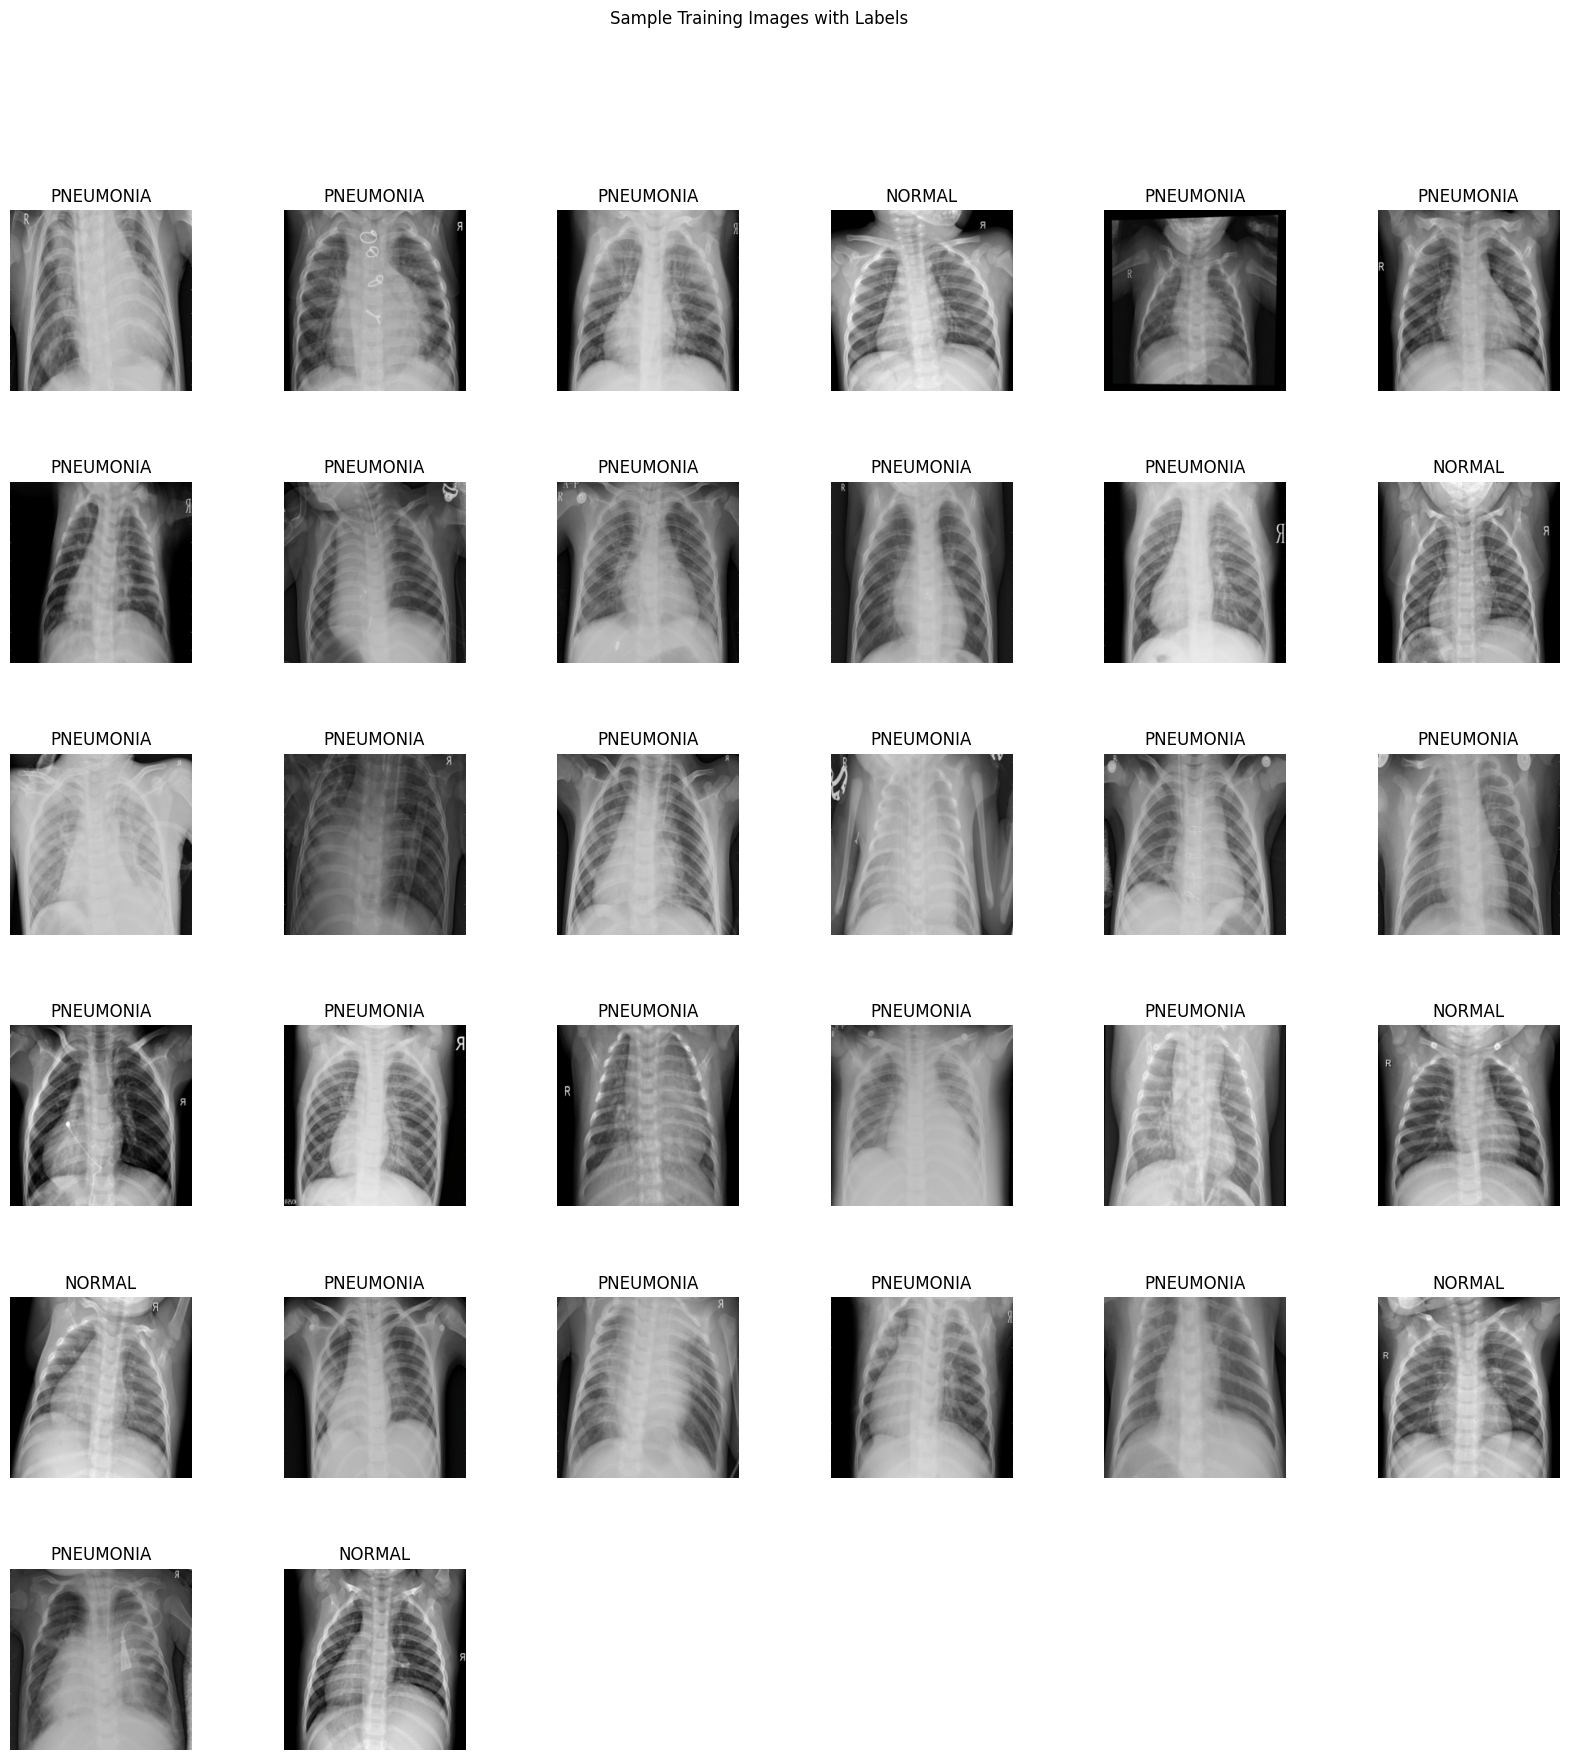

In [5]:
# Sanity check - visualize a batch of images
def imshow(inp, title=None):
    """Show a batch of images."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize=(50, 50)) 
    plt.imshow(inp)
    plt.axis('off')  # Turn off axis
    if title is not None:
        plt.title(title)
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch and visualize with class labels
def imshow_with_labels(inp, classes, title=None):
    """Show a batch of images along with their class labels."""
    num_images = min(inp.size(0), 36)  # Ensure a maximum of 36 images are displayed
    fig, axes = plt.subplots(6, 6, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            img = inp[i].numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            ax.imshow(img)
            ax.set_title(train_dataset.classes[classes[i]])
            ax.axis('off')
        else:
            ax.axis('off')  # Hide axes for empty subplots
    if title is not None:
        plt.suptitle(title)
    plt.show()

# Visualize the batch of images along with class labels
imshow_with_labels(inputs, classes, title='Sample Training Images with Labels')

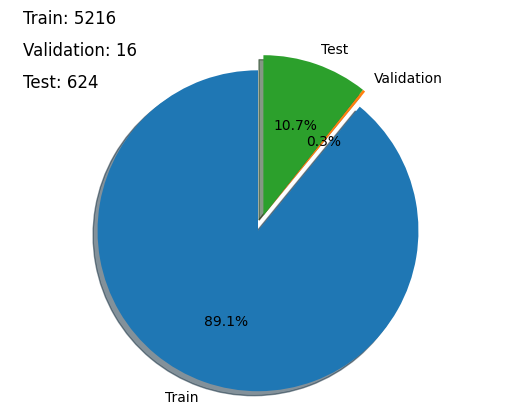

In [6]:
# Calculate sizes of each dataset
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Train', 'Validation', 'Test'
sizes = [train_size, val_size, test_size]
explode = (0.1, 0, 0)  # only "explode" the 1st slice (i.e., 'Train')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Add annotations to display the sizes
for i, size in enumerate(sizes):
    ax1.annotate(f'{labels[i]}: {size}', xy=(0, 0), xytext=(-1.5, 1.2 - i * 0.2), fontsize=12, color='black')

plt.show()


In [7]:

# Clear TorchVision cache to resolve hash value mismatch
torch.hub._download_url_to_file = torch.hub.download_url_to_file
torchvision.models.vgg16(pretrained=True)


# Define the device for computation (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained VGG-16 model
model = torchvision.models.vgg16(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Modify the fully connected layer
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 2)  # Modify the fully connected layer for binary classification (2 classes)

# Move the model to the appropriate device
model = model.to(device)

# Define hyperparameters
learning_rate = 0.001
batch_size = 32
num_epochs = 30

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print the modified VGG model architecture
print(model)

# Sanity check to see if the model is moved to the correct device
print(f"Model is using {device}")




/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:

validation_subset_size = int(len(train_dataset) * 0.2)  

# Shuffle the indices of the training dataset
indices = list(range(len(train_dataset)))
random.shuffle(indices)

# Extract a subset of the training dataset for validation
validation_indices = indices[:validation_subset_size]
remaining_indices = indices[validation_subset_size:]

# Create datasets and dataloaders
val_subset_dataset = torch.utils.data.Subset(train_dataset, validation_indices)
train_subset_dataset = torch.utils.data.Subset(train_dataset, remaining_indices)

# Append the subset of training data to the validation dataset
val_dataset += val_subset_dataset

# Remove the subset data from the original training dataset
train_dataset = train_subset_dataset

# Create data loaders for the updated datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


# Sanity check: Print the sizes of the training and validation datasets
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Training dataset size: 4173
Validation dataset size: 1059


In [9]:
# Initialize variables for tracking best validation loss and corresponding epoch
best_val_loss = float('inf')
best_epoch = 0

# Define the number of epochs to wait if validation loss doesn't improve
patience = 5
counter = 0  # Counter to track the number of epochs with no improvement

# Initialize lists to store training and validation loss, and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


# Define the learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    # Calculate training loss and accuracy
    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100. * correct / total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    # Calculate validation loss and accuracy
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100. * correct / total
    
    # Step the learning rate scheduler
    scheduler.step()
    
    # Print training progress
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, '
          f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')
    
    # Store the values for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    # Check if validation loss improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        counter = 0
    else:
        counter += 1
        
    # Check for early stopping
    if counter >= patience:
        print(f'Validation loss did not improve for {patience} epochs. Stopping training.')
        break

# Print the best validation loss and corresponding epoch
print(f'Best validation loss: {best_val_loss:.4f} at epoch {best_epoch+1}')

Epoch [1/30], Train Loss: 0.2288, Train Acc: 90.94%, Val Loss: 0.1506, Val Acc: 95.09%, Learning Rate: 0.001000
Epoch [2/30], Train Loss: 0.1740, Train Acc: 92.95%, Val Loss: 0.1519, Val Acc: 94.24%, Learning Rate: 0.001000
Epoch [3/30], Train Loss: 0.1814, Train Acc: 93.00%, Val Loss: 0.1602, Val Acc: 93.96%, Learning Rate: 0.001000
Epoch [4/30], Train Loss: 0.1615, Train Acc: 93.55%, Val Loss: 0.1231, Val Acc: 95.28%, Learning Rate: 0.001000
Epoch [5/30], Train Loss: 0.1525, Train Acc: 93.89%, Val Loss: 0.1356, Val Acc: 94.90%, Learning Rate: 0.001000
Epoch [6/30], Train Loss: 0.1618, Train Acc: 93.67%, Val Loss: 0.1259, Val Acc: 95.47%, Learning Rate: 0.001000
Epoch [7/30], Train Loss: 0.1519, Train Acc: 93.89%, Val Loss: 0.1176, Val Acc: 95.75%, Learning Rate: 0.001000
Epoch [8/30], Train Loss: 0.1655, Train Acc: 93.46%, Val Loss: 0.1368, Val Acc: 94.90%, Learning Rate: 0.001000
Epoch [9/30], Train Loss: 0.1599, Train Acc: 93.63%, Val Loss: 0.1199, Val Acc: 95.75%, Learning Rate: 0

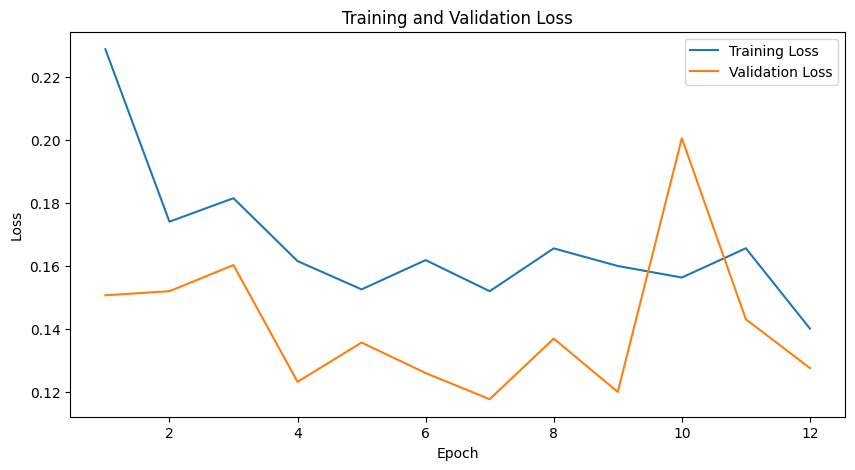

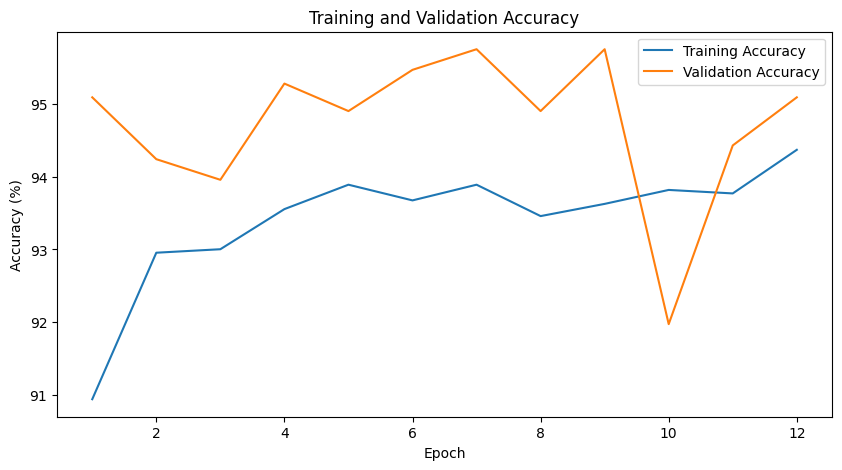

In [10]:

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


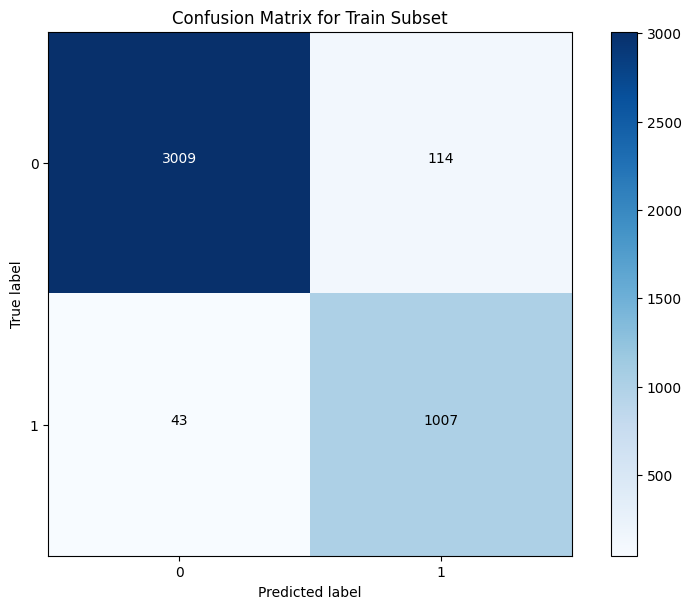

Metrics for Train subset:
Accuracy: 0.9624
Precision: 0.8983
Recall: 0.9590
F1 Score: 0.9277
Confusion Matrix:
[[3009  114]
 [  43 1007]]

Classification Report for Train subset:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      3123
           1       0.90      0.96      0.93      1050

    accuracy                           0.96      4173
   macro avg       0.94      0.96      0.95      4173
weighted avg       0.96      0.96      0.96      4173




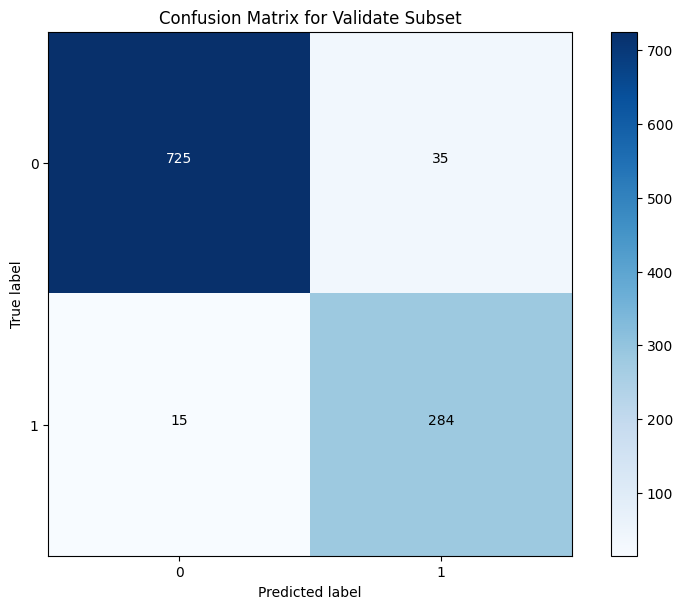

Metrics for Validate subset:
Accuracy: 0.9528
Precision: 0.8903
Recall: 0.9498
F1 Score: 0.9191
Confusion Matrix:
[[725  35]
 [ 15 284]]

Classification Report for Validate subset:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       760
           1       0.89      0.95      0.92       299

    accuracy                           0.95      1059
   macro avg       0.94      0.95      0.94      1059
weighted avg       0.95      0.95      0.95      1059




In [11]:
def evaluate_model(loader, name):
    """
    Evaluate the trained model on the specified data loader and plot the confusion matrix.

    Args:
        loader (DataLoader): DataLoader containing the dataset to evaluate.
        name (str): Name of the subset (e.g., "Train", "Validate").

    Returns:
        None
    """
    model.eval()
    predictions = []
    ground_truths = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().numpy())
            ground_truths.extend(targets.cpu().numpy())

    accuracy = accuracy_score(ground_truths, predictions)
    precision = precision_score(ground_truths, predictions)
    recall = recall_score(ground_truths, predictions)
    f1 = f1_score(ground_truths, predictions)
    
    # Generate confusion matrix
    cm = confusion_matrix(ground_truths, predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name} Subset')
    plt.colorbar()
    classes = [str(i) for i in range(len(cm))]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    print(f"Metrics for {name} subset:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}\n")

    # Generate classification report
    report = classification_report(ground_truths, predictions)
    print(f"Classification Report for {name} subset:\n{report}\n")

# Evaluate on train subset
evaluate_model(train_loader, "Train")

# Evaluate on validate subset
evaluate_model(val_loader, "Validate")

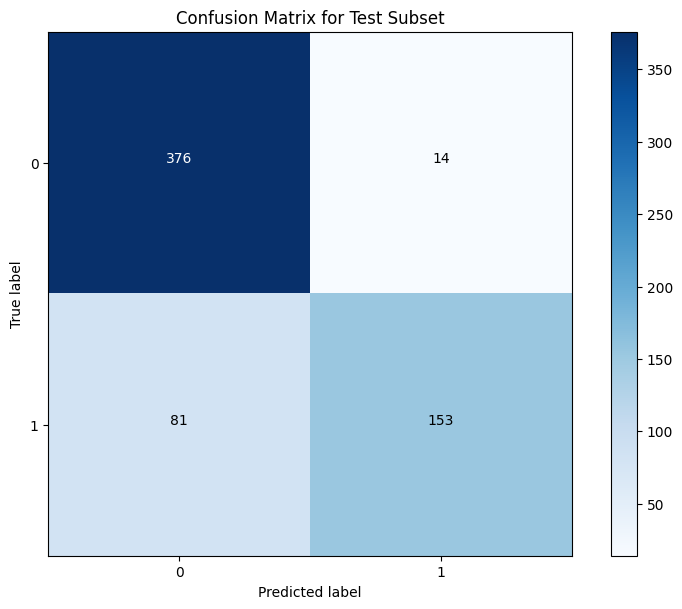

Metrics for Test subset:
Accuracy: 0.8478
Precision: 0.9162
Recall: 0.6538
F1 Score: 0.7631
Confusion Matrix:
[[376  14]
 [ 81 153]]

Classification Report for Test subset:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       390
           1       0.92      0.65      0.76       234

    accuracy                           0.85       624
   macro avg       0.87      0.81      0.83       624
weighted avg       0.86      0.85      0.84       624




In [12]:

def evaluate_model_test(loader, name):
    """
    Evaluate the trained model on the specified data loader (test set), store true labels, predicted labels, and input images for visualization, and plot the confusion matrix.

    Args:
        loader (DataLoader): DataLoader containing the test dataset to evaluate.
        name (str): Name of the subset (e.g., "Test").

    Returns:
        true_labels (list): True labels.
        pred_labels (list): Predicted labels.
        input_images (list): Input images for visualization.
        accuracy (float): Accuracy.
        precision (float): Precision.
        recall (float): Recall.
        f1 (float): F1 Score.
        confusion_matrix (array): Confusion matrix.
    """
    model.eval()
    predictions = []
    ground_truths = []
    input_images = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().numpy())
            ground_truths.extend(targets.cpu().numpy())
            input_images.extend(inputs.cpu().numpy())

    accuracy = accuracy_score(ground_truths, predictions)
    precision = precision_score(ground_truths, predictions)
    recall = recall_score(ground_truths, predictions)
    f1 = f1_score(ground_truths, predictions)
    
    # Generate confusion matrix
    cm = confusion_matrix(ground_truths, predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name} Subset')
    plt.colorbar()
    classes = [str(i) for i in range(len(cm))]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    print(f"Metrics for {name} subset:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}\n")

    # Generate classification report
    report = classification_report(ground_truths, predictions)
    print(f"Classification Report for {name} subset:\n{report}\n")

    return ground_truths, predictions, input_images, accuracy, precision, recall, f1, cm

# Call the function and store the returned values
true_labels, pred_labels, input_images, accuracy, precision, recall, f1, cm = evaluate_model_test(test_loader, "Test")


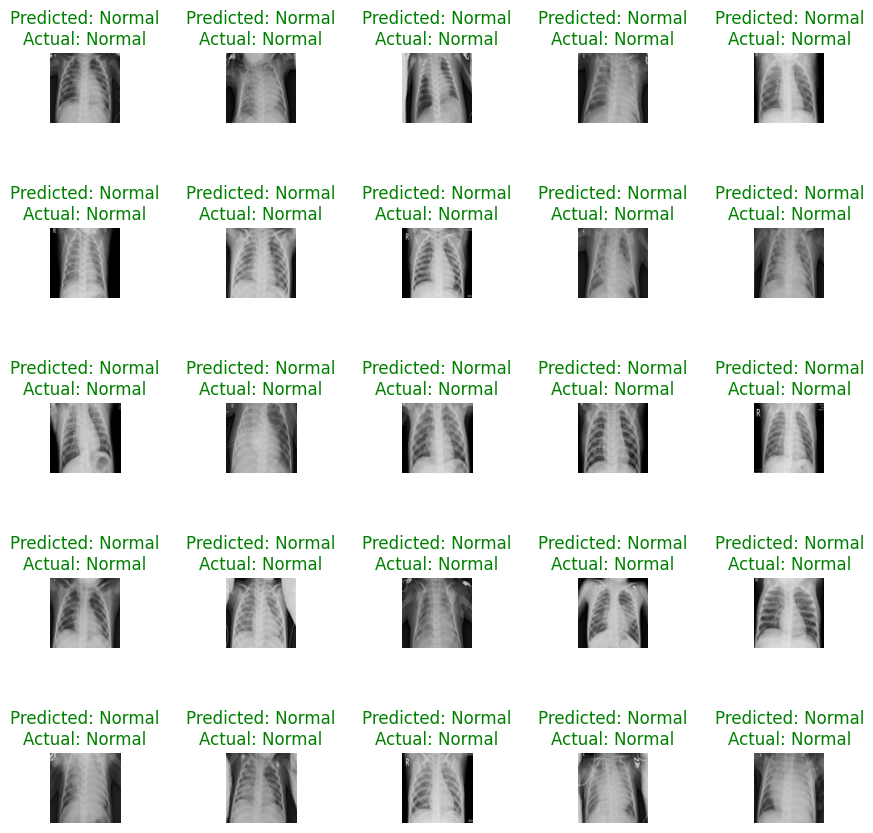

In [13]:
# Define the class names
class_names = ['Normal', 'Pneumonia']

# Visualize the images along with predicted and true labels
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
fig.subplots_adjust(hspace=1.5, wspace=1.5)
x = 0
for i in range(5):
    for j in range(5):
        # Get the image and labels
        inp = input_images[x].squeeze()
        true_label = true_labels[x]
        pred_label = pred_labels[x]

        # Normalize the image for display
        inp = inp.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

        # Display the image
        axes[i, j].imshow(inp)

        # Set the title with the predicted and actual labels
        title = "Predicted: {}\nActual: {}".format(class_names[pred_label], class_names[true_label])
        color = 'green' if pred_label == true_label else 'red'
        axes[i, j].set_title(title, color=color)

        # Hide the axes
        axes[i, j].axis('off')

        # Move to the next image
        x += 1

plt.show()
